# OpenEO Connection to Google Earth Engine

In [1]:
import openeo
import logging
from openeo.auth.auth_bearer import BearerAuth
logging.basicConfig(level=logging.INFO)

In [2]:
# Define constants

# Connection
GEE_DRIVER_URL = "http://giv-openeo.uni-muenster.de:8080/v0.3"
OUTPUT_FILE = "/tmp/openeo_gee_output.png"
OUTFORMAT = "png"

# Auth
USER = "group1"
PASSWORD = "test123"

# Data
PRODUCT_ID = "COPERNICUS/S2"

DATE_START = "2017-01-01T00:00:00Z"
DATE_END = "2017-01-31T23:59:59Z"

IMAGE_WEST = 16.138916
IMAGE_EAST = 16.524124
IMAGE_NORTH = 48.320647
IMAGE_SOUTH = 48.138600
IMAGE_SRS = "EPSG:4326"

# Processes
NDVI_RED = "B4"
NDVI_NIR = "B8A"

STRECH_COLORS_MIN = -1
STRECH_COLORS_MAX = 1

In [3]:
# Connect with GEE backend
connection = openeo.connect(GEE_DRIVER_URL, auth_type=BearerAuth, auth_options={"username": USER, "password": PASSWORD})
connection

In [4]:
# Get available processes from the back end.
processes = connection.list_processes()
processes

[{'description': 'Counts the number of images with a valid mask in a time series for all bands of the input dataset.',
  'name': 'count_time',
  'parameters': {'imagery': {'description': 'EO data to process.',
    'required': True,
    'schema': {'format': 'eodata', 'type': 'object'}}},
  'returns': {'description': 'Processed EO data.',
   'schema': {'format': 'eodata', 'type': 'object'}}},
 {'description': 'Allows to extract one or multiple bands of multi-band raster image collection.\nBands can be chosen either by band id.',
  'name': 'filter_bands',
  'parameters': {'bands': {'description': 'string or array of strings containing band ids.',
    'required': True,
    'schema': {'items': {'type': 'string'}, 'type': ['string', 'array']}},
   'imagery': {'description': 'EO data to process.',
    'required': True,
    'schema': {'format': 'eodata', 'type': 'object'}}},
  'returns': {'description': 'Processed EO data.',
   'schema': {'format': 'eodata', 'type': 'object'}},
  'summary': 'F

In [5]:
# Retrieve the list of available collections
collections = connection.list_collections()

list(collections)[:2]

[{'description': 'Starting in 2009, the Earth Observation Team of the Science and Technology\nBranch (STB) at Agriculture and Agri-Food Canada (AAFC) began the process\nof generating annual crop type digital maps. Focusing on the Prairie\nProvinces in 2009 and 2010, a Decision Tree (DT) based methodology was\napplied using optical (Landsat-5, AWiFS, DMC) and radar (Radarsat-2) based\nsatellite images. Beginning with the 2011 growing season, this activity has\nbeen extended to other provinces in support of a national crop inventory.\nTo date this approach can consistently deliver a crop inventory that meets\nthe overall target accuracy of at least 85% at a final spatial resolution of\n30m (56m in 2009 and 2010).\n',
  'extent': {'spatial': [-51.24, 36.83, -135.17, 62.25],
   'temporal': ['2009-01-01T00:00:00Z', None]},
  'license': 'proprietary',
  'links': [{'href': 'https://earthengine.openeo.org/v0.3/collections/AAFC/ACI',
    'rel': 'self'},
   {'href': 'https://earthengine.openeo.o

In [6]:
# Get detailed information about a collection
process = connection.describe_collection('COPERNICUS/S2')
process

{'description': 'Sentinel-2 is a wide-swath, high-resolution, multi-spectral\nimaging mission supporting Copernicus Land Monitoring studies,\nincluding the monitoring of vegetation, soil and water cover,\nas well as observation of inland waterways and coastal areas.\n\nThe Sentinel-2 data contain 13 UINT16 spectral bands representing\nTOA reflectance scaled by 10000. See the [Sentinel-2 User Handbook](https://sentinel.esa.int/documents/247904/685211/Sentinel-2_User_Handbook)\nfor details. In addition, three QA bands are present where one\n(QA60) is a bitmask band with cloud mask information. For more\ndetails, [see the full explanation of how cloud masks are computed.](https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-2-msi/level-1c/cloud-masks)\n\nEach Sentinel-2 product (zip archive) may contain multiple\ngranules. Each granule becomes a separate Earth Engine asset.\nEE asset ids for Sentinel-2 assets have the following format:\nCOPERNICUS/S2/20151128T002653_20151128T10

In [7]:
# Select collection product
datacube = connection.imagecollection("COPERNICUS/S2")

datacube.graph

{'name': 'COPERNICUS/S2', 'process_id': 'get_collection'}

In [8]:
# Specifying the date range and the bounding box
datacube = datacube.filter_bbox(west=IMAGE_WEST, east=IMAGE_EAST, north=IMAGE_NORTH,
                                             south=IMAGE_SOUTH, crs=IMAGE_SRS)
datacube = datacube.filter_daterange(extent=[DATE_START, DATE_END])

datacube.graph

{'extent': ['2017-01-01T00:00:00Z', '2017-01-31T23:59:59Z'],
 'imagery': {'extent': {'crs': 'EPSG:4326',
   'east': 16.524124,
   'north': 48.320647,
   'south': 48.1386,
   'west': 16.138916},
  'imagery': {'name': 'COPERNICUS/S2', 'process_id': 'get_collection'},
  'process_id': 'filter_bbox'},
 'process_id': 'filter_daterange'}

In [9]:
# Applying some operations on the data
datacube = datacube.ndvi(red=NDVI_RED, nir=NDVI_NIR)
datacube = datacube.min_time()

datacube.graph

{'imagery': {'imagery': {'extent': ['2017-01-01T00:00:00Z',
    '2017-01-31T23:59:59Z'],
   'imagery': {'extent': {'crs': 'EPSG:4326',
     'east': 16.524124,
     'north': 48.320647,
     'south': 48.1386,
     'west': 16.138916},
    'imagery': {'name': 'COPERNICUS/S2', 'process_id': 'get_collection'},
    'process_id': 'filter_bbox'},
   'process_id': 'filter_daterange'},
  'nir': 'B8A',
  'process_id': 'NDVI',
  'red': 'B4'},
 'process_id': 'min_time'}

In [10]:
# Sending the job to the backend
job = connection.create_job(datacube.graph)
job.start_job()
job

In [13]:
# Describe Job
job.describe_job()

{'budget': None,
 'costs': 0,
 'description': None,
 'job_id': 'tS4QZGDf1d72OZex',
 'output': {'format': 'PNG', 'parameters': {}},
 'plan': 'free',
 'process_graph': {'imagery': {'imagery': {'extent': ['2017-01-01T00:00:00Z',
     '2017-01-31T23:59:59Z'],
    'imagery': {'extent': {'crs': 'EPSG:4326',
      'east': 16.524124,
      'north': 48.320647,
      'south': 48.1386,
      'west': 16.138916},
     'imagery': {'name': 'COPERNICUS/S2', 'process_id': 'get_collection'},
     'process_id': 'filter_bbox'},
    'process_id': 'filter_daterange'},
   'nir': 'B8A',
   'process_id': 'NDVI',
   'red': 'B4'},
  'process_id': 'min_time'},
 'status': 'finished',
 'submitted': '2019-05-21T12:51:57Z',
 'title': None,
 'updated': '2019-05-21T12:51:57Z'}

In [14]:
# Download job result
job.download_results(OUTPUT_FILE)

job

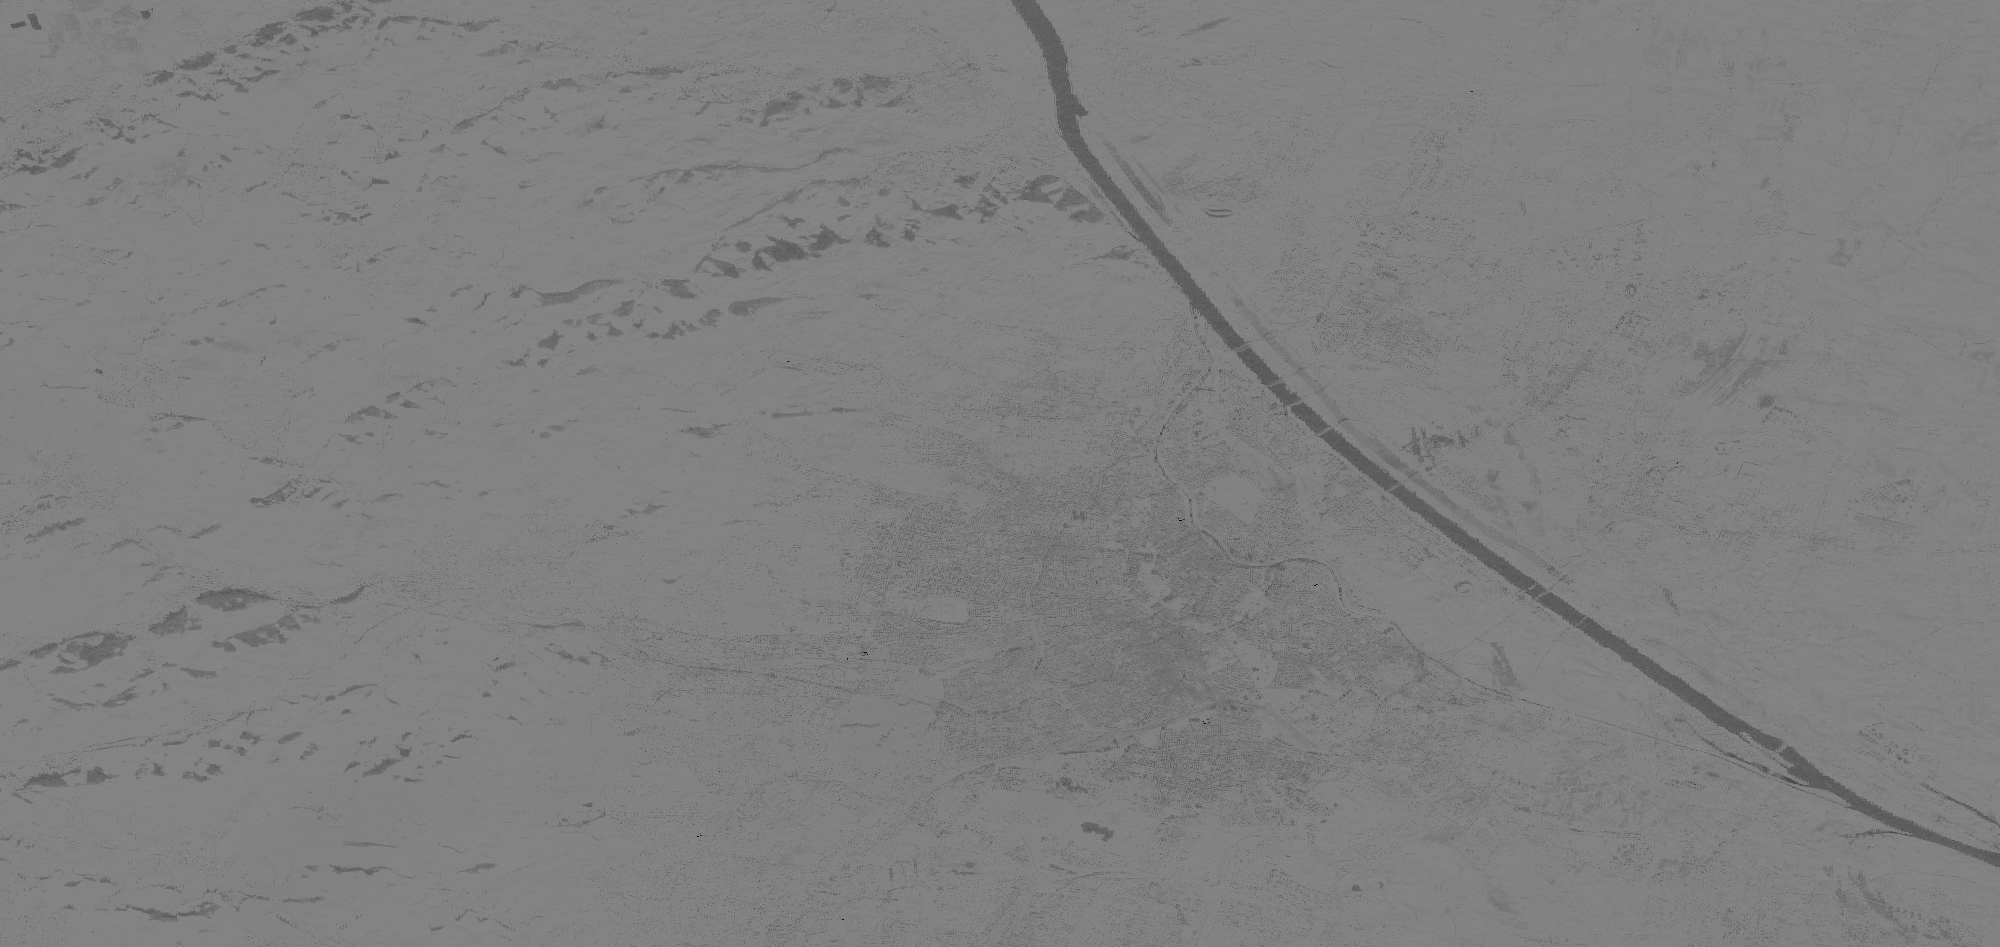

In [15]:
# Showing the result
from IPython.display import Image
result = Image(filename=OUTPUT_FILE)

result